This notebook is inspired by https://www.mathworks.com/help/wavelet/examples/time-frequency-analysis-with-the-continuous-wavelet-transform.html

See also https://www.mathworks.com/help/wavelet/gs/continuous-wavelet-transform-and-scale-based-analysis.html

Info on chirps can be found at https://en.wikipedia.org/wiki/Chirp

In [2]:
%pylab inline
rcParams['figure.figsize'] = (15, 9)
import pycwt

Populating the interactive namespace from numpy and matplotlib


# Linear chirp
We begin by making a making a oscillatory signal that increases linearly in frequency

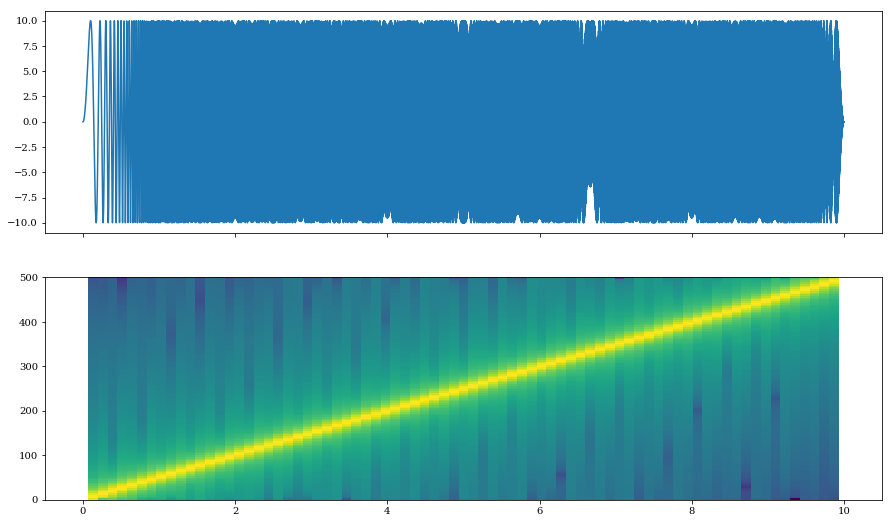

In [130]:
duration = 10
sampling_rate = 1000
sampling_period = 1 / sampling_rate
time = arange(0, duration, sampling_period)
f_start = 0
f_stop = 500
amplitude = 10

frequency = f_start + (f_stop - f_start) * time / (2 * duration)
data = amplitude * sin(2 * pi * frequency * time)

fig, axs = subplots(2, 1, sharex=True)
axs[0].plot(time, data)

axs[1].specgram(data, Fs=sampling_rate);

We do a continous wavelet transform (cwt) with a morlet wavelet

In [203]:
mother = pycwt.Morlet(60)
freqs = arange(1, 500)

wave, scales, freqs, coi, fft, fftfreqs = pycwt.cwt(data, sampling_period, freqs=freqs, wavelet=mother)

power = (numpy.abs(wave)) ** 2
power /= scales[:, None] #rectify the power spectrum according to the suggestions proposed by Liu et al. (2007)

To mask areas where there are edge effects we use the cone of influence (coi)

In [219]:
def mask_coi(power, freqs, coi):
    periods = 1 / freqs
    for i in range(power.shape[1]):
        mask = periods > coi[i]
        power[mask, i] = nan

One have to flick the wave number (w0) in the Morlet to get approximately constant amplitude.

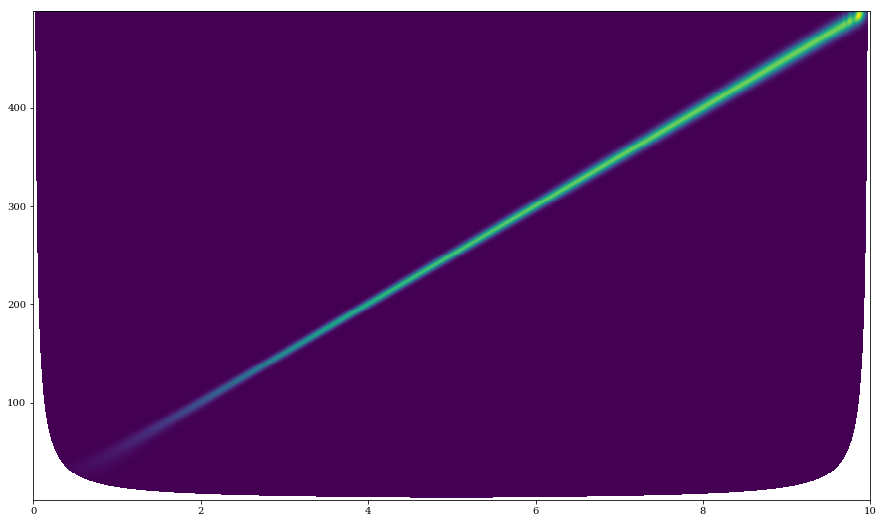

In [205]:
mask_coi(power, freqs, coi)

imshow(power, extent=[0, duration, freqs.min(), freqs.max()], aspect='auto', origin='lower')

The furier spectrum shows that the amplitude is constant

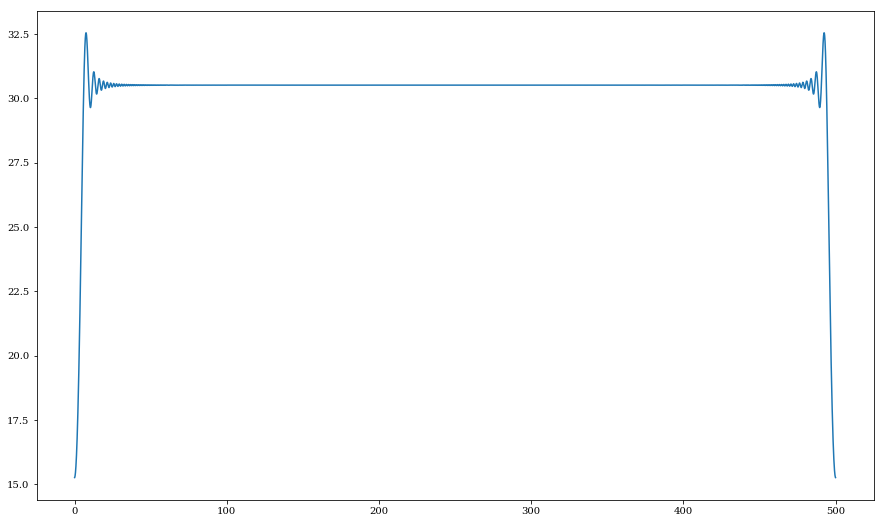

In [199]:
fft_power = numpy.abs(fft) ** 2
plot(fftfreqs, fft_power)

# Exponential chirp
How does the morlet wavelet behave on a signal where the freqency increases exponentially

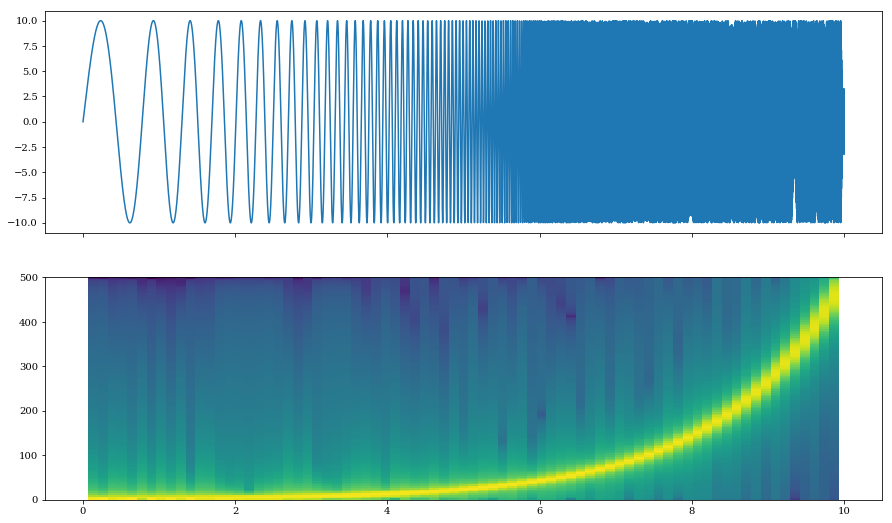

In [207]:
duration = 10
sampling_rate = 1000
time = arange(0, duration, 1/sampling_rate)
f_start = 1
f_stop = 500
amplitude = 10

k = (f_stop / f_start) **(1 / duration)

data = amplitude * sin(2 * pi * f_start * (k**time - 1) / log(k))

fig, axs = subplots(2, 1, sharex=True)
axs[0].plot(time, data)

axs[1].specgram(data, Fs=sampling_rate);

In [210]:
mother = pycwt.Morlet(6)
freqs = arange(1, 500)

wave, scales, freqs, coi, fft, fftfreqs = pycwt.cwt(data, sampling_period, freqs=freqs, wavelet=mother)

power = (numpy.abs(wave)) ** 2
fft_power = numpy.abs(fft) ** 2
power /= scales[:, None]

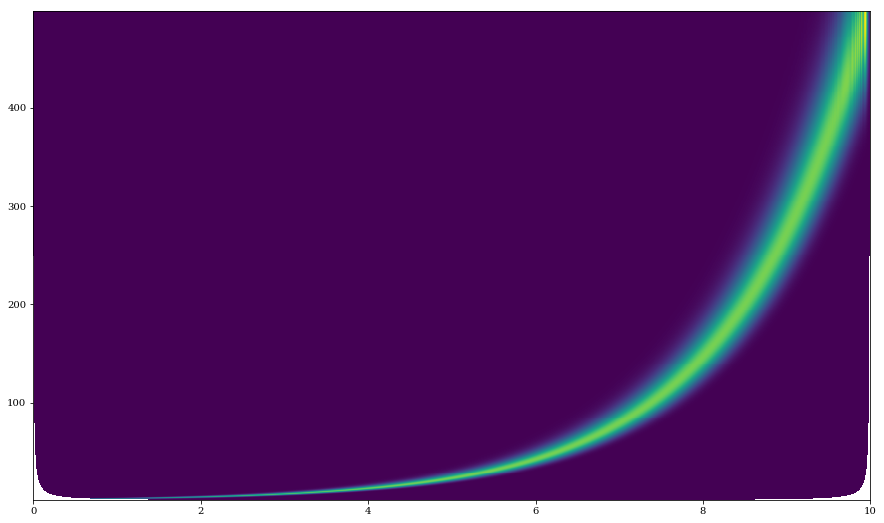

In [211]:
mask_coi(power, freqs, coi)

imshow(power, extent=[0, duration, freqs.min(), freqs.max()], aspect='auto', origin='lower')

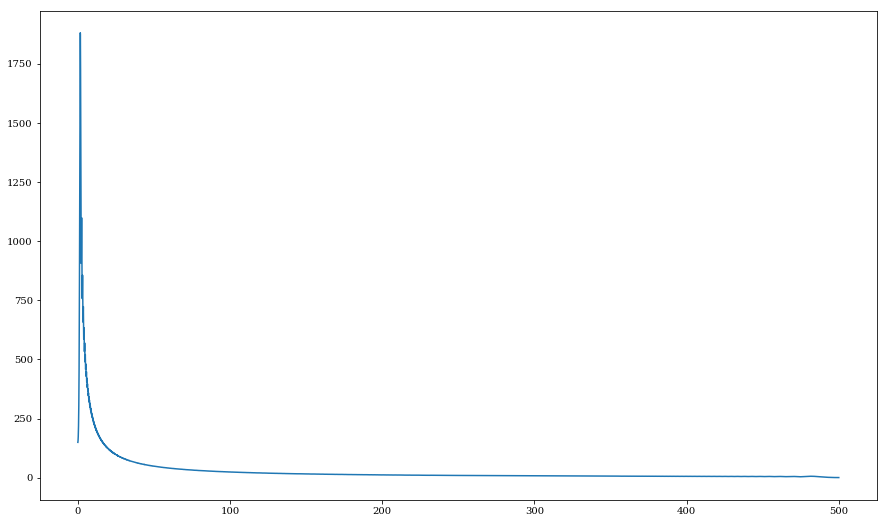

In [46]:
plot(fftfreqs, fft_power)

# Detection of Transients in Oscillations Using the CWT
There are certain situations in time-frequency analysis where the CWT can provide a more informative time-frequency transform than the short-time Fourier transform. One such situation occurs when the signal is corrupted by transients. The appearance and disappearance of these transients often has physical significance. Therefore, it is important to be able to localize these transients in addition to characterizing oscillatory components in the signal. To simulate this, create a signal consisting of two sine waves with frequencies of 150 and 200 Hz. The sampling frequency is 1 kHz. The sine waves have disjoint time supports. The 150-Hz sine wave occurs between 100 and 300 milliseconds. The 200-Hz sine wave occurs from 700 milliseconds to 1 second. Additionally, there are two transients at 222 and 800 milliseconds. The signal is corrupted by noise.

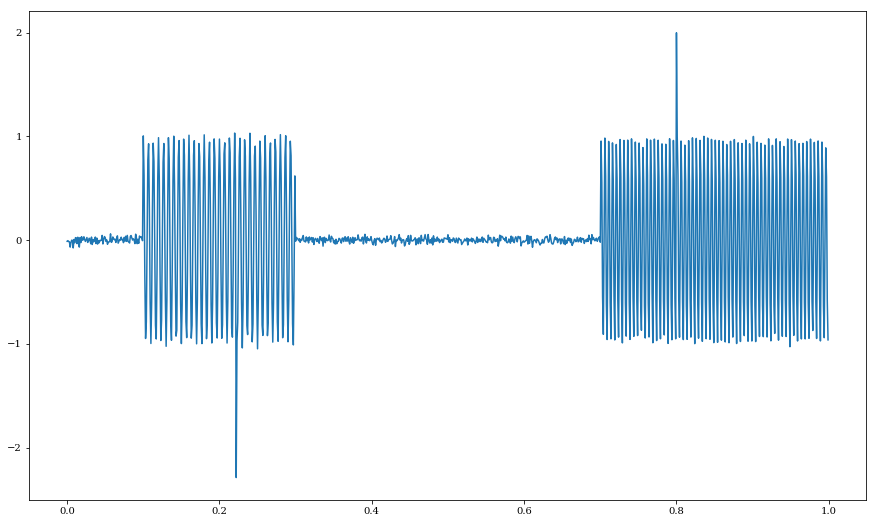

In [212]:
duration = 1
sampling_period = 0.001
time = arange(0, duration, sampling_period)

noise = 0.025 * randn(time.size)
data = cos(2 * pi * 150 * time) * ((time >= 0.1) & (time < 0.3)) + sin(2 * pi * 200 * time) * (time > 0.7)
data = data + noise
data[[222, 800]] += [-2, 2]
plot(time, data)

Text(0.5, 0, 'Seconds')

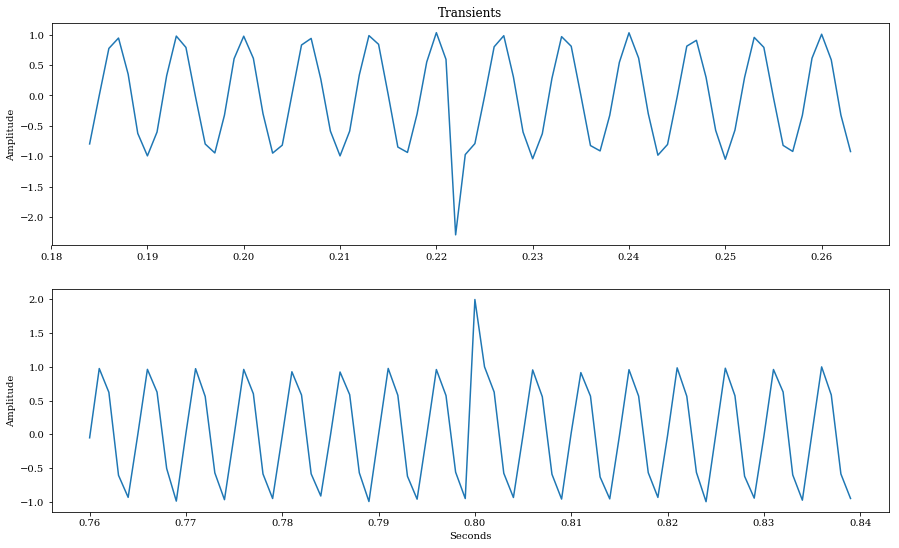

In [213]:
fig, axs = subplots(2, 1)
axs[0].set_title('Transients')
axs[0].plot(time[184:264], data[184:264])
axs[0].set_ylabel('Amplitude')

axs[1].plot(time[760:840], data[760:840])
axs[1].set_ylabel('Amplitude')
axs[1].set_xlabel('Seconds')

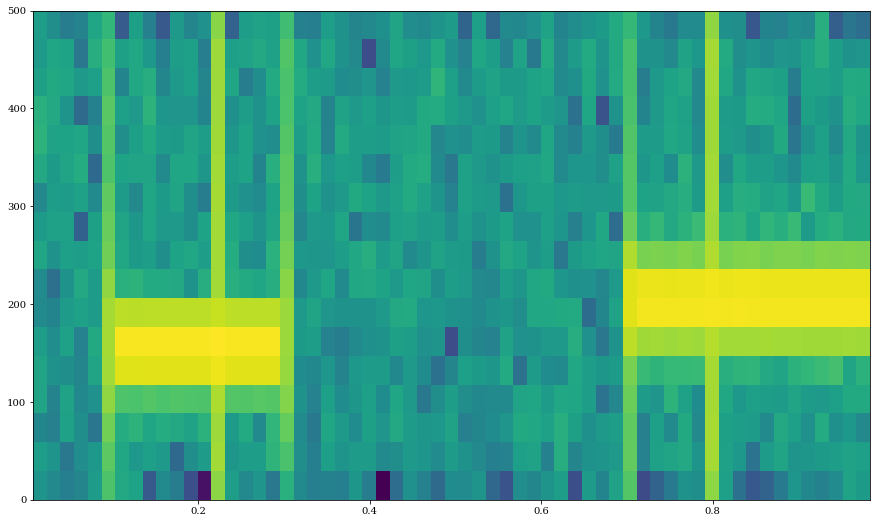

In [216]:
specgram(data, NFFT=32, noverlap=16, Fs=1 / sampling_period);

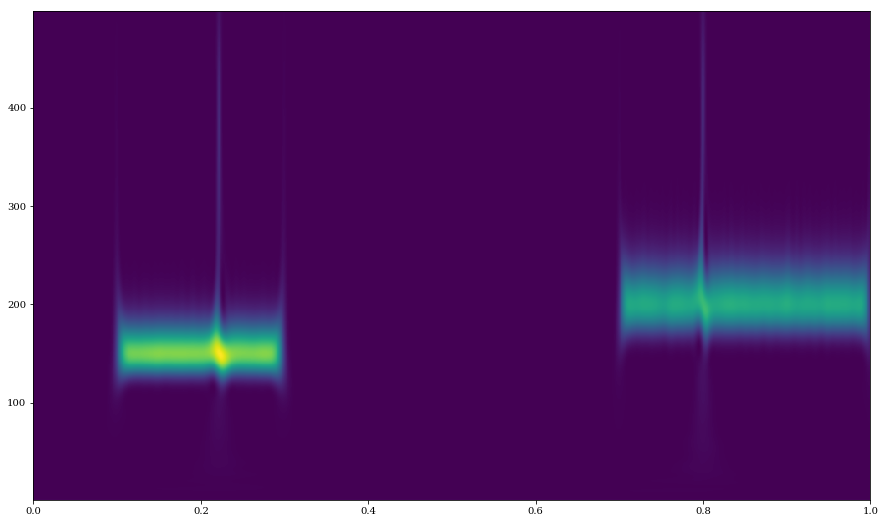

In [217]:
mother = pycwt.Morlet(6)
freqs = arange(1, 500)

wave, scales, freqs, coi, fft, fftfreqs = pycwt.cwt(data, sampling_period, freqs=freqs, wavelet=mother)

power = (numpy.abs(wave)) ** 2
fft_power = numpy.abs(fft) ** 2

imshow(power, extent=[0, duration, freqs.min(), freqs.max()], aspect='auto', origin='lower')

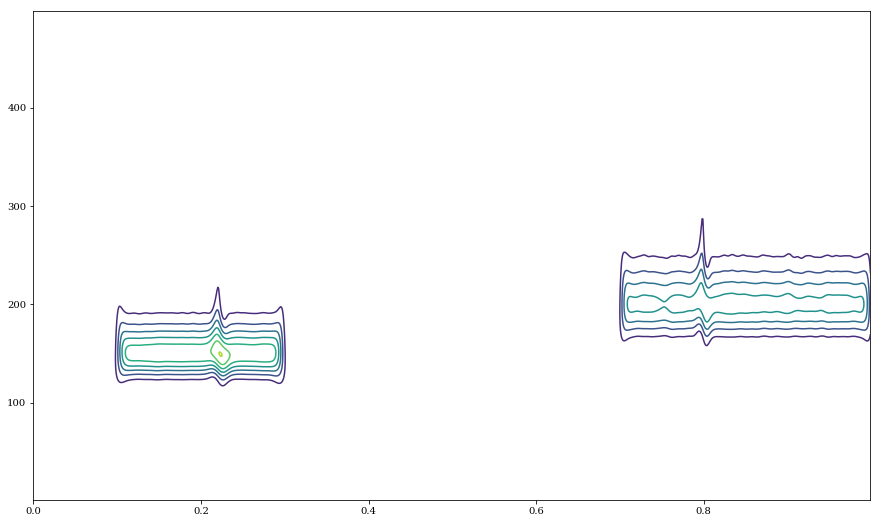

In [218]:
contour(time, freqs, power)